<b> Exploratory data analysis 1</b>

My data consists of content-related data of game pages on Steam - when a user arrives at a page, he/she sees contents related to the game such as: the game description, updates/news related to the game, number of gameplay screenshots/videos - as well as a score/rating for the game. We call games that have a rating "labeled". Of the data set I collected, about 40% of games are unlabeled.

The latter can be further broken up into three measures: the total number of user reviews, the % of those reviews that were positive, and an overall rating. The rating is related to the % positive reviews: < 40% positive reviews gives a "negative" sentiment rating, between 40-60% is "mixed", and above that is "positive".

The problem surrounding my project is to use labeled data to train a model that assigns/predicts the scoring/rating for unlabeled data.

This can be approached two ways:
- Train a regression model using the score.
- Train a classification model using the sentiment (negative, mixed, positive).

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

now = datetime(year=2019, month=5, day=26).timestamp()

# note: mean_time is in days
cont_vars = ['num_pre','num_post','mean_time', 'release_date','len_description', 'num_movies',
                 'num_images','score','num_reviews','sentiment']
cat_vars = ['is_action', 'is_adventure', 'is_casual', 'is_mmo', 'is_racing', 'is_rpg', 'is_strategy', 'is_simulation', 'is_sports']

data = pd.read_csv('../data/features_vec_all.csv', usecols=cont_vars+cat_vars)

# convert from release date to months since release
for i in data.index:
    data.at[i, 'release_date'] = timedelta(seconds=int(now-data.at[i, 'release_date'])).days / 30.0
    
data['release_date'].quantile([0.25, 0.5, 0.75, 0.9])

0.25    17.800000
0.50    32.866667
0.75    49.200000
0.90    65.306667
Name: release_date, dtype: float64

<b> look at the distribution of score received by label

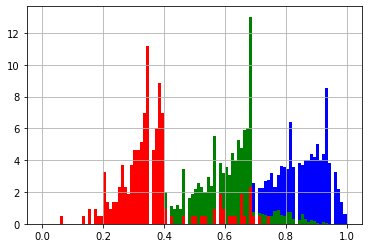

In [172]:
data.loc[data['sentiment']==1]['score'].hist(bins=100, range=(0,1), density=True, color='blue')
data.loc[data['sentiment']==0]['score'].hist(bins=100, range=(0,1),density=True,color='green')
data.loc[data['sentiment']==-1]['score'].hist(bins=100, range=(0,1),density=True,color='red')

<b>The score distribution over all classes is skewed:

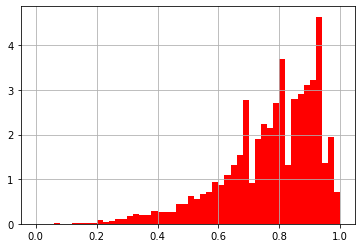

In [173]:
data['score'].hist(bins=50, range=(0,1),density=True,color='red')

<b> look at the distribution of reviews received by label, pretty similar across different labels:

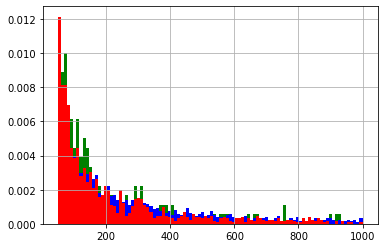

In [174]:
data.loc[data['sentiment']==-1]['num_reviews'].hist(bins=100, range=(50, 1000),density=True,color='green')
data.loc[data['sentiment']==1]['num_reviews'].hist(bins=100, range=(50, 1000), density=True, color='blue')
data.loc[data['sentiment']==0]['num_reviews'].hist(bins=100, range=(50, 1000),density=True,color='red')


<b> Some data need to be normalized. For example:
1. the number of updates since release depends on how long it has been released for.
2. a game can accumulate its score in a shorter or longer amount of time, depending on how long it has been released for.

In [175]:
med_release_date = data['release_date'].median()
max_release_date = data['release_date'].max()
med_reviews = data['num_reviews'].median()
mean_reviews = data['num_reviews'].mean()

for i in data.index:
    n_post = data.at[i, 'num_post']
    n_pre = data.at[i, 'num_pre']
    
    # scores for games with sufficient (>100) reviews
    # games can have a high rating but either been released for a long time,
    # or it has been out for not too long but still very popular amongst users

#    if data.at[i, 'score'] > 0.5:
#        data.at[i, 'score'] *= (1 + (data.at[i, 'release_date'] - med_release_date) / max_release_date)
#    else:
#        data.at[i, 'score'] *= (1 - (data.at[i, 'release_date'] - med_release_date) / max_release_date)
        
    if data.at[i, 'num_reviews'] > med_reviews:
        data.at[i, 'num_reviews'] *= data.at[i, 'score']*(1 + (data.at[i, 'release_date'] - med_release_date) / max_release_date)
    else:
        data.at[i, 'num_reviews'] *= data.at[i, 'score']*(1 - (data.at[i, 'release_date'] - med_release_date) / max_release_date)       
        
    # games that have been out longer can have more updates
    # -> '# updates per month since release'
    data.at[i, 'num_post'] /= (1 + data.at[i, 'release_date'])

    data.at[i, 'mean_time'] /= 30.0 # convert days->months

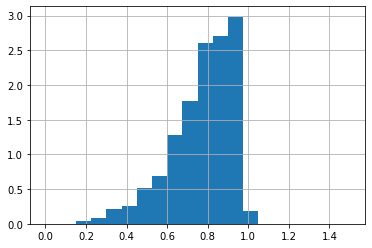

In [176]:
data['score'].hist(bins=20, range=(0, 1.5), density=True)

In [177]:
# rescaling some variables
data['num_pre'] = np.log(1 + 100*data['num_pre'])
data['num_post'] = np.log(1 + 200*data['num_post'])
data['mean_time'] = np.log(1 + 200*data['mean_time'])
data['score'] = np.log(1 + data['score'])
data['num_reviews'] = np.log(data['num_reviews'])

data['num_pre'] = (data['num_pre'] - data['num_pre'].mean()) / data['num_pre'].std()
data['num_post'] = (data['num_post'] - data['num_post'].mean()) / data['num_post'].std()
data['mean_time'] = (data['mean_time'] - data['mean_time'].mean()) / data['mean_time'].std()
data['score'] = (data['score'] - data['score'].mean()) / data['score'].std()
data['num_reviews'] = (data['num_reviews'] - data['num_reviews'].mean()) / data['num_reviews'].std()


data.corr(method='spearman')

,num_pre,num_post,mean_time,release_date,len_description,num_movies,num_images,score,num_reviews,sentiment,is_action,is_adventure,is_casual,is_mmo,is_racing,is_rpg,is_simulation,is_sports,is_strategy
num_pre,1.000000,0.388869,-0.321335,-0.293267,0.262835,0.293986,0.231957,-0.028500,0.161393,-0.026774,0.090465,0.021313,-0.154059,0.064792,0.036100,0.088749,0.117715,0.036068,0.109216
num_post,0.388869,1.000000,-0.452508,-0.530305,0.279497,0.280408,0.179178,0.110099,0.241260,0.072595,0.027002,0.010869,-0.072318,0.152612,-0.000853,0.157441,0.173635,0.020404,0.109764
mean_time,-0.321335,-0.452508,1.000000,0.439401,-0.149990,-0.169102,-0.058122,0.062485,0.020857,0.069629,-0.062383,0.021947,0.078016,-0.125748,-0.025705,-0.081437,-0.109501,-0.040601,-0.089337
release_date,-0.293267,-0.530305,0.439401,1.000000,-0.053741,-0.161507,0.063449,-0.070020,0.125915,-0.058191,0.030731,-0.057900,-0.063948,-0.085318,-0.002322,-0.043538,-0.128894,-0.031259,-0.000121
len_description,0.262835,0.279497,-0.149990,-0.053741,1.000000,0.237408,0.329729,-0.055510,0.086468,-0.031375,0.043120,0.015194,-0.191414,0.071017,0.024716,0.161720,0.136916,0.047253,0.159944
num_movies,0.293986,0.280408,-0.169102,-0.161507,0.237408,1.000000,0.207393,0.011080,0.117528,0.006976,0.084475,0.077873,-0.105054,0.012242,0.033972,0.021864,0.042528,0.050857,0.007345
num_images,0.231957,0.179178,-0.058122,0.063449,0.329729,0.207393,1.000000,-0.089281,0.085082,-0.053306,0.112033,0.020727,-0.133241,0.038245,0.033995,0.084556,0.102679,0.023148,0.096694
score,-0.028500,0.110099,0.062485,-0.070020,-0.055510,0.011080,-0.089281,1.000000,0.410585,0.748574,-0.063666,-0.026470,0.058178,-0.168319,-0.031687,-0.055914,-0.137796,-0.033981,-0.139392
num_reviews,0.161393,0.241260,0.020857,0.125915,0.086468,0.117528,0.085082,0.410585,1.000000,0.309071,-0.004752,0.007338,-0.064643,0.052252,-0.027269,0.049785,0.020566,-0.033838,0.008918
sentiment,-0.026774,0.072595,0.069629,-0.058191,-0.031375,0.006976,-0.053306,0.748574,0.309071,1.000000,-0.054715,-0.014100,0.049818,-0.154779,-0.019230,-0.040414,-0.119550,-0.019350,-0.103530


We have modified the number of total reviews by the score to get the total number of positive reviews. We then penalize this by a factor that takes into account how long the game has been released: in general, it makes a good (bad) score even better (worse) if it has been released for a long time.

This modified score is in essence also a proxy for sentiment rating / % positive score (we don't just want to fit to the total number of reviews as is, since it's indicative of how many people have rated the game, but not the cumulative rating).

Looking at the correlations, we only found two variables that weakly correlate with this modified score. We'll try to fit them with some regression models below.

In [178]:
data_pos = data[data['sentiment']==1]
data_mixed = data[data['sentiment']==0]
data_neg = data[data['sentiment']==-1]

-0.2844542647510309 0.8950944242505998
-0.07049659130028671 1.0342239503478743
0.03883330318746327 0.9864388862587041


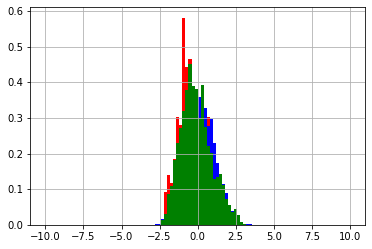

In [179]:
data.loc[data['sentiment']==-1]['num_post'].hist(bins=100, range=(-10, 10),density=True,color='red')
data.loc[data['sentiment']==1]['num_post'].hist(bins=100, range=(-10, 10), density=True, color='blue')
data.loc[data['sentiment']==0]['num_post'].hist(bins=100, range=(-10, 10),density=True,color='green')


print(data.loc[data['sentiment']==-1]['num_post'].mean(), data.loc[data['sentiment']==-1]['num_post'].var())
print(data.loc[data['sentiment']==0]['num_post'].mean(), data.loc[data['sentiment']==0]['num_post'].var())
print(data.loc[data['sentiment']==1]['num_post'].mean(), data.loc[data['sentiment']==1]['num_post'].var())

0.06419795511477659 1.1306089670537067
0.03360971236072624 1.0555524608851627
-0.014948961563169043 0.9737459649268854


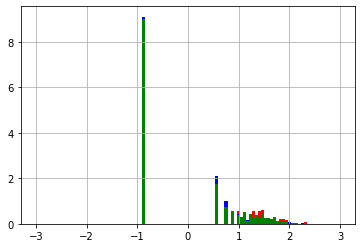

In [180]:
# this doesn't normalize well...
data.loc[data['sentiment']==-1]['num_pre'].hist(bins=100, range=(-3, 3),density=True,color='red')
data.loc[data['sentiment']==1]['num_pre'].hist(bins=100, range=(-3, 3), density=True, color='blue')
data.loc[data['sentiment']==0]['num_pre'].hist(bins=100, range=(-3, 3),density=True,color='green')


print(data.loc[data['sentiment']==-1]['num_pre'].mean(), data.loc[data['sentiment']==-1]['num_pre'].var())
print(data.loc[data['sentiment']==0]['num_pre'].mean(), data.loc[data['sentiment']==0]['num_pre'].var())
print(data.loc[data['sentiment']==1]['num_pre'].mean(), data.loc[data['sentiment']==1]['num_pre'].var())

-0.2353325504157946 0.8950944242505998
-0.08021447201287084 1.0342239503478743
0.03977693956785817 0.9864388862587041


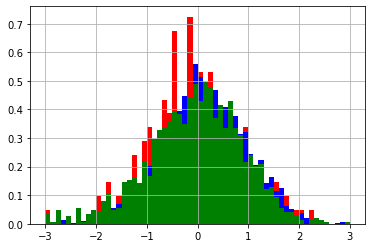

In [181]:
data.loc[data['sentiment']==-1]['mean_time'].hist(bins=60, range=(-3, 3),density=True,color='red')
data.loc[data['sentiment']==1]['mean_time'].hist(bins=60, range=(-3, 3), density=True, color='blue')
data.loc[data['sentiment']==0]['mean_time'].hist(bins=60, range=(-3, 3),density=True,color='green')


print(data.loc[data['sentiment']==-1]['mean_time'].mean(), data.loc[data['sentiment']==-1]['num_post'].var())
print(data.loc[data['sentiment']==0]['mean_time'].mean(), data.loc[data['sentiment']==0]['num_post'].var())
print(data.loc[data['sentiment']==1]['mean_time'].mean(), data.loc[data['sentiment']==1]['num_post'].var())

<b> Try fitting the data to the modified score, which is basically the raw number of positive interaction penalized by the amount of time a game has been released. </b>

Try first with simple regression, then a Random Forest:

In [222]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from collections import Counter

X = data[['num_post','num_pre','mean_time']].values
Y = data['num_reviews'].values.reshape(-1,1)


-7.065355825268696


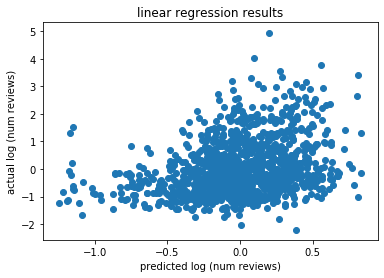

In [223]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

ridge = Ridge(alpha=0.1)
ridge.fit(x_train, y_train.ravel())

y_pred = ridge.predict(x_test)
print(r2_score(y_pred, y_test.ravel()))

plt.scatter(y_pred, y_test.ravel())
plt.title('linear regression results')
plt.xlabel('predicted log (num reviews)');
plt.ylabel('actual log (num reviews)');

-0.6377117472308893


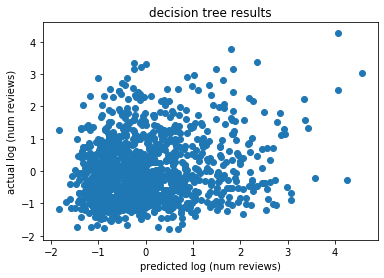

In [236]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

dtr = DecisionTreeRegressor(max_depth=100)
dtr.fit(x_train, y_train.ravel())

y_pred = dtr.predict(x_test)
print(r2_score(y_pred, y_test.ravel()))

plt.scatter(y_pred, y_test.ravel())
plt.title('decision tree results')
plt.xlabel('predicted log (num reviews)');
plt.ylabel('actual log (num reviews)');

-1.0666242246877018


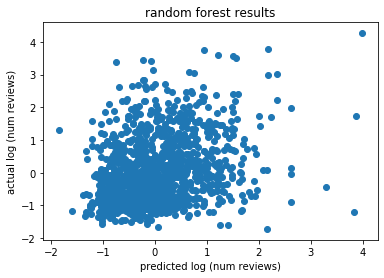

In [225]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

rfr = RandomForestRegressor(n_estimators=3, max_depth=100, bootstrap=True)
rfr.fit(x_train, y_train.ravel())

y_pred = rfr.predict(x_test)
print(r2_score(y_pred, y_test.ravel()))

plt.scatter(y_pred, y_test.ravel())
plt.title('random forest results')
plt.xlabel('predicted log (num reviews)');
plt.ylabel('actual log (num reviews)');

<b> While single decision tree tries not to overfit the predictor variables (the Random Forest with more than one tree, gets worse R2 score...), the variance of the model doesn't capture the true values.